# Protected CRR
It would be interesting to contrast with ACI...

In [5]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from online_cp import PluginMartingale
from scipy.optimize import brentq
from tqdm.notebook import tqdm
from online_cp import ConformalRidgeRegressor

def quantile(p, cdf_func):
# Invert CDF using root-finding (find x such that cdf(x) = p)
    return brentq(lambda x: cdf_func(x) - p, 0, 1)

rnd_gen = np.random.default_rng(2024)

In [6]:
wine_quality = fetch_ucirepo(id=186) 
wine = wine_quality.data.original

X = wine.drop(columns=['quality', 'color']).values
Y = wine['quality'].astype('float').values

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

In [7]:
def compute_p_value(y, precomputed):
    A = precomputed['A']
    B = precomputed['B']
    try:
        E = A + y*B

        Alpha = np.zeros_like(A)

        for i, e in enumerate(E):
            alpha = min((E >= e).sum(), (E<=e).sum())
            Alpha[i] = alpha

        alpha_y = Alpha[-1]
        leq = np.where(Alpha <= alpha_y)[0].shape[0]

        p_y = leq/Alpha.shape[0]
    except TypeError:
        p_y = rnd_gen.uniform(0, 1)
    return p_y

In [8]:
epsilon = 0.1

eps = epsilon

delta = 0.01
M = X.shape[0]
gamma_opt = (max(epsilon, 1-epsilon))/(delta*M - 1)
gamma = gamma_opt

cp = ConformalRidgeRegressor(0.1)

martingale = PluginMartingale(warnings=False)

p_values = np.empty_like(Y)
protected_p_values = np.empty_like(Y)
aci_p_values = np.empty_like(Y)

base_predictions = np.empty(shape=(Y.shape[0], 2))
protected_predictions = np.empty(shape=(Y.shape[0], 2))
aci_predictions = np.empty(shape=(Y.shape[0], 2))

eps_array = np.empty_like(Y)
epsilon_hat_array = np.empty_like(Y)

Err = 0
err = 0

for i, (obj, lab) in tqdm(enumerate(zip(X, Y)), total=Y.shape[0]):

    # Base prediction
    Gamma, precomputed = cp.predict(obj, epsilon=epsilon, return_update=True)
    base_predictions[i, :] = Gamma

    # Protected prediction
    # Protected significance level
    func = lambda x: martingale.B_n(x) - epsilon
    epsilon_hat = brentq(func, 0, 1)

    protected_Gamma = cp.predict(obj, epsilon=epsilon_hat)
    protected_predictions[i, :] = protected_Gamma
    epsilon_hat_array[i] = epsilon_hat

    aci_Gamma = cp.predict(obj, epsilon=eps)
    aci_predictions[i, :] = aci_Gamma
    eps_array[i] = eps

    # Compute p-values
    p = compute_p_value(lab, precomputed)
    protected_p = martingale.B_n(p)
    aci_inv = lambda x: (x - eps + gamma*err) / gamma
    aci_p = aci_inv(p)

    martingale.update_martingale_value(p)

    p_values[i] = p
    protected_p_values[i] = protected_p
    aci_p_values[i] = aci_p

    # ACI update
    err = cp.err(aci_Gamma, lab)
    Err += err
    eps += gamma*(epsilon - err)

    cp.learn_one(obj, lab)

  0%|          | 0/6497 [00:00<?, ?it/s]

/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/regressors.py:352: UserWarning: Significance level epsilon is too small for training set. Need at least 20 examples. Increase or add more examples
  warnings.warn(f'Significance level epsilon is too small for training set. Need at least {int(np.ceil(2/epsilon))} examples. Increase or add more examples')
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/regressors.py:352: UserWarning: Significance level epsilon is too small for training set. Need at least 21 examples. Increase or add more examples
  warnings.warn(f'Significance level epsilon is too small for training set. Need at least {int(np.ceil(2/epsilon))} examples. Increase or add more examples')
/home/johan/Documents/PhD/PREMACOP/OnlineConformalPrediction/src/online_cp/regressors.py:352: UserWarning: Significance level epsilon is too small for training set. Need at least 19 examples. Increase or add more examples
  warnings.warn(f'

In [9]:
(p_values <= epsilon).mean()

0.11035862705864245

In [10]:
(protected_p_values <= epsilon).mean()

0.09789133446205942

In [11]:
def winkler(intervals, true_values, alpha):
    idx_informative = np.argwhere(intervals[:, 1] < np.inf).flatten()
    intervals = intervals[idx_informative, :]
    # Define intervals and true values
    L = intervals[:, 0]  # Lower bounds
    U = intervals[:, 1]  # Upper bounds
    y = true_values[idx_informative]      # True values

    # Compute components of Winkler score
    width = U - L  # Interval width
    below = L - y  # Difference when true value is below L
    above = y - U  # Difference when true value is above U

    # Compute Winkler score for each case
    winkler_score = np.where(
        y < L,  # Case 1: y < L
        width + (2 / alpha) * below,
        np.where(
            y > U,  # Case 3: y > U
            width + (2 / alpha) * above,
            width  # Case 2: L <= y <= U
        )
    )
    return winkler_score

def avg_width(intervals):
    idx_informative = np.argwhere(intervals[:, 1] < np.inf).flatten()
    intervals = intervals[idx_informative, :]
    return (intervals[:, 1] - intervals[:, 0]).mean()

Base

In [12]:
print('Base')
print(f'Error rate: {(p_values <= epsilon).mean()}')
print(f'Winkler: {winkler(base_predictions, Y, epsilon).sum()}')
print(f'Width: {avg_width(base_predictions)}')
print(f'Uninformative: {1-(base_predictions[:,1] < np.inf).mean()}')

Base
Error rate: 0.11035862705864245
Winkler: 26376.346710540045
Width: 2.9495782739553373
Uninformative: 0.0029244266584577128


Protected

In [13]:
print('Protected')
print(f'Error rate: {(protected_p_values <= epsilon).mean()}')
print(f'Winkler: {winkler(protected_predictions, Y, epsilon).sum()}')
print(f'Width: {avg_width(protected_predictions)}')
print(f'Uninformative: {1-(protected_predictions[:,1] < np.inf).mean()}')

Protected
Error rate: 0.09789133446205942
Winkler: 26369.24249894336
Width: 3.0918303545803982
Uninformative: 0.0032322610435585597


ACI

In [14]:
print('Protected')
print(f'Error rate: {Err/Y.shape[0]}')
print(f'Winkler: {winkler(aci_predictions, Y, epsilon).sum()}')
print(f'Width: {avg_width(aci_predictions)}')
print(f'Uninformative: {1-(aci_predictions[:,1] < np.inf).mean()}')

Protected
Error rate: 0.09989225796521471
Winkler: 26396.44784908517
Width: 3.1169180149413496
Uninformative: 0.0038479298137601425


Text(0.5, 1.0, 'Protected CRR')

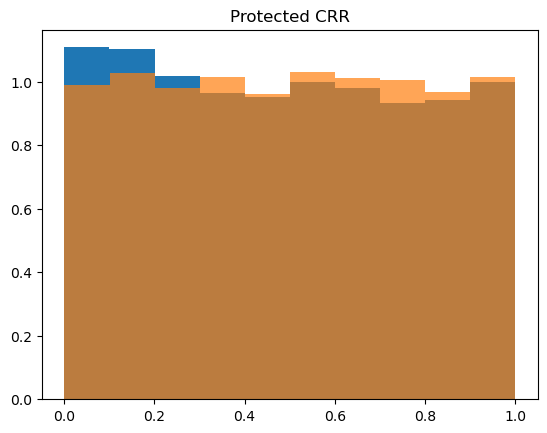

In [19]:
protected_p_values = martingale.B_n(p_values)
plt.hist(p_values, density=True)
plt.hist(protected_p_values, density=True, alpha=0.7)
plt.title('Protected CRR')

(array([0.00557581, 0.01589296, 0.01479297, 0.01445159, 0.01264988,
        0.01443262, 0.01321884, 0.0137878 , 0.01316195, 0.0052534 ]),
 array([-11.37649488,  -3.26078553,   4.85492383,  12.97063318,
         21.08634254,  29.20205189,  37.31776125,  45.4334706 ,
         53.54917996,  61.66488931,  69.78059866]),
 <BarContainer object of 10 artists>)

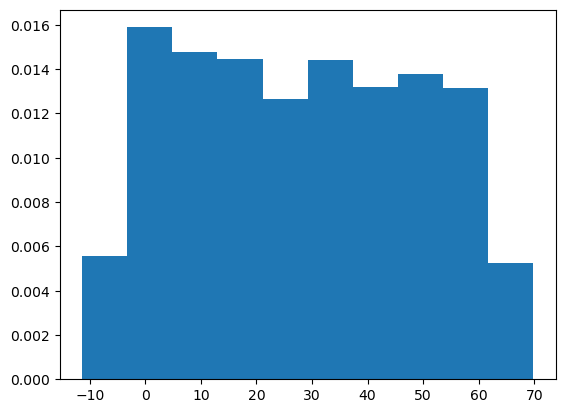

In [20]:
plt.hist(aci_p_values, density=True)

Text(0.5, 1.0, 'Approximate calibration plot CRR')

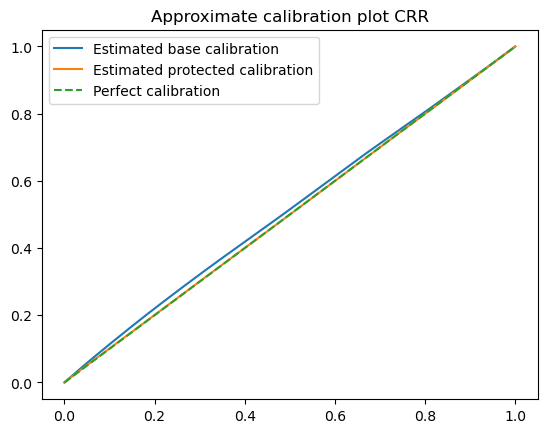

In [16]:
calibration_martingale = PluginMartingale(warnings=False) 
for p in protected_p_values:
    calibration_martingale.update_martingale_value(p)

plt.plot(
    np.linspace(0, 1, 1000),
    martingale.B_n(np.linspace(0, 1, 1000)),
    label='Estimated base calibration'
)
plt.plot(
    np.linspace(0, 1, 1000),
    calibration_martingale.B_n(np.linspace(0, 1, 1000)),
    label='Estimated protected calibration'
)
plt.plot(
    np.linspace(0, 1, 1000),
    np.linspace(0, 1, 1000),
    linestyle='--',
    label='Perfect calibration'
)
plt.legend()
plt.title('Approximate calibration plot CRR')

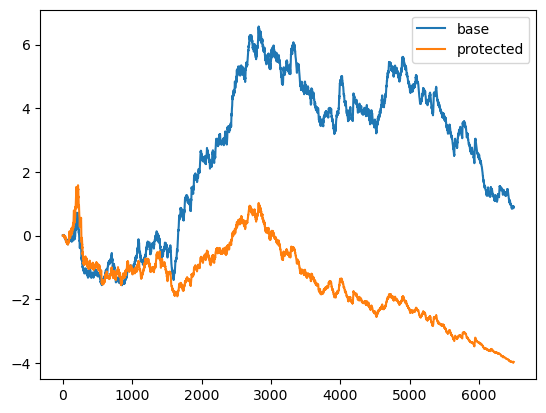

In [17]:
plt.plot(martingale.log10_martingale_values, label='base')
plt.plot(calibration_martingale.log10_martingale_values, label='protected')
plt.legend()

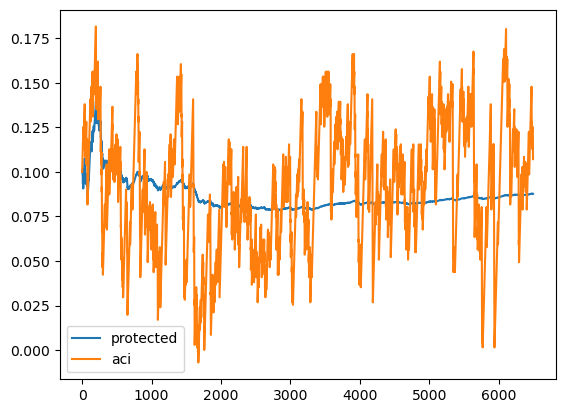

In [18]:
plt.plot(epsilon_hat_array, label='protected')
plt.plot(eps_array, label='aci')
plt.legend()

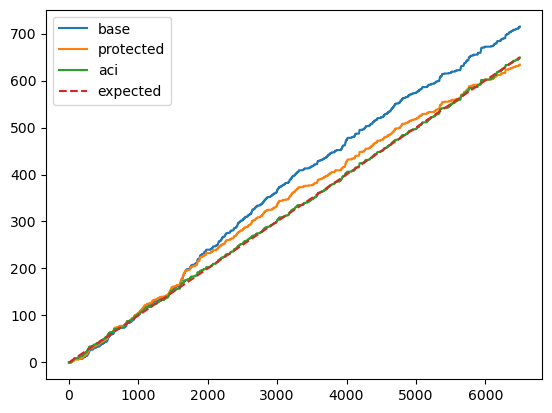

In [34]:
plt.plot(np.cumsum(((base_predictions[:,0] > Y) + (base_predictions[:, 1] < Y)).astype(int)), label='base')
plt.plot(np.cumsum(((protected_predictions[:,0] > Y) + (protected_predictions[:, 1] < Y)).astype(int)), label='protected')
plt.plot(np.cumsum(((aci_predictions[:,0] > Y) + (aci_predictions[:, 1] < Y)).astype(int)), label='aci')
plt.plot(epsilon*np.array([i for i,_ in enumerate(Y)]), label='expected', linestyle='--')
plt.legend()